In [1]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [2]:
import tensorflow as tf
import datetime

In [3]:
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

def create_model():
  return tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28), name='layers_flatten'),
    tf.keras.layers.Dense(512, activation='relu', name='layers_dense'),
    tf.keras.layers.Dropout(0.2, name='layers_dropout'),
    tf.keras.layers.Dense(10, activation='softmax', name='layers_dense_2')
  ])

In [4]:
import os

In [5]:
os.curdir

'.'

In [6]:
model = create_model()

In [7]:
root_logdir = os.path.join(os.curdir, "my_logs")

def get_run_logdir(): 
    import time 
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S") 
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=run_logdir, histogram_freq=1)

In [8]:
run_logdir

'.\\my_logs\\run_2023_07_24-11_02_12'

In [9]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [10]:
model.fit(x=x_train, 
          y=y_train, 
          epochs=30, 
          validation_data=(x_test, y_test), 
          callbacks=[tensorboard_callback])

Epoch 1/30
1875/1875 [==============================] - 9s 4ms/step - loss: 0.2189 - accuracy: 0.9347 - val_loss: 0.1115 - val_accuracy: 0.9657
Epoch 2/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0966 - accuracy: 0.9704 - val_loss: 0.0781 - val_accuracy: 0.9754
Epoch 3/30
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0674 - accuracy: 0.9791 - val_loss: 0.0834 - val_accuracy: 0.9742
Epoch 4/30
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0530 - accuracy: 0.9830 - val_loss: 0.0746 - val_accuracy: 0.9761
Epoch 5/30
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0419 - accuracy: 0.9863 - val_loss: 0.0774 - val_accuracy: 0.9769
Epoch 6/30
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0377 - accuracy: 0.9876 - val_loss: 0.0665 - val_accuracy: 0.9802
Epoch 7/30
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0325 - accuracy: 0.9888 - val_loss: 0.0656 - val_accuracy:

In [ ]:
%tensorboard --logdir=.\\my_logs

In [12]:
from tensorflow import keras

In [13]:
from sklearn.datasets import fetch_california_housing 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler

In [14]:
housing = fetch_california_housing()

In [15]:
X_train_full, X_test, y_train_full, y_test = train_test_split( housing.data, housing.target)
X_train, X_valid, y_train, y_valid = train_test_split( X_train_full, y_train_full)

In [16]:
scaler = StandardScaler() 
X_train_scaled = scaler.fit_transform(X_train) 
X_valid_scaled = scaler.transform(X_valid) 
X_test_scaled = scaler.transform(X_test)

In [17]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    options = {"input_shape": input_shape}
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu", **options))
        options = {}
    model.add(keras.layers.Dense(1, **options))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model
    

In [22]:
%pip install scikeras[tensorflow]

  Obtaining dependency information for scikeras[tensorflow] from https://files.pythonhosted.org/packages/41/6f/53606bacb79e64f30d23410e15f3034447e97a33850d5d4366abdcf7ed84/scikeras-0.11.0-py3-none-any.whl.metadata
Note: you may need to restart the kernel to use updated packages.


In [23]:
import scikeras
from scikeras.wrappers import KerasRegressor

In [24]:
keras_reg =  KerasRegressor(build_model)

In [25]:
keras_reg.fit(X_train_scaled, y_train, epochs=100,
              validation_data=(X_valid_scaled, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])
mse_test = keras_reg.score(X_test_scaled, y_test)
y_pred = keras_reg.predict(X_test[:3])

Epoch 1/100
363/363 [==============================] - 1s 2ms/step - loss: 1.3802 - val_loss: 0.7364
Epoch 2/100
363/363 [==============================] - 1s 2ms/step - loss: 0.6714 - val_loss: 0.6231
Epoch 3/100
363/363 [==============================] - 0s 1ms/step - loss: 0.5859 - val_loss: 0.5680
Epoch 4/100
363/363 [==============================] - 0s 1ms/step - loss: 0.5405 - val_loss: 0.8665
Epoch 5/100
363/363 [==============================] - 0s 1ms/step - loss: 0.5140 - val_loss: 0.5158
Epoch 6/100
363/363 [==============================] - 0s 1ms/step - loss: 0.5055 - val_loss: 0.6492
Epoch 7/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4797 - val_loss: 0.4875
Epoch 8/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4784 - val_loss: 0.5876
Epoch 9/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4570 - val_loss: 0.4860
Epoch 10/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4581 - val_lo

In [26]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

In [27]:
import numpy as np

In [53]:
def build_model(n_hidden, n_neurons, meta):
    model = keras.models.Sequential()
    # note that I added the meta parameter, you can access all of the SciKeras attributes
    # https://scikeras.readthedocs.io/en/latest/generated/scikeras.wrappers.KerasRegressor.html
    n_features_in_ = meta["n_features_in_"]
    model.add(keras.layers.InputLayer(input_shape=(n_features_in_, )))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    return model  # note that I return an un-compiled model here, SciKeras will compile it for you!


keras_reg = scikeras.wrappers.KerasRegressor(
    build_model,
    n_neurons=30,
    n_hidden=1,
    optimizer__lr=3e-3,  # just specify parameters here, you won't have to edit build_model to add/remove things you're tuning
    optimizer=keras.optimizers.SGD,  # note that I am giving SciKeras a class, not an instance
   loss="mse",
)
    

param_distribs = {
    "n_hidden" : [0, 1, 2, 3],
    "n_neurons" : np.arange(1, 100, 10),
    "optimizer__lr" : np.arange(3e-4, 3e-2, 0.3*(1e-2 - 1e-4))
}

In [45]:
np.arange(1, 100)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

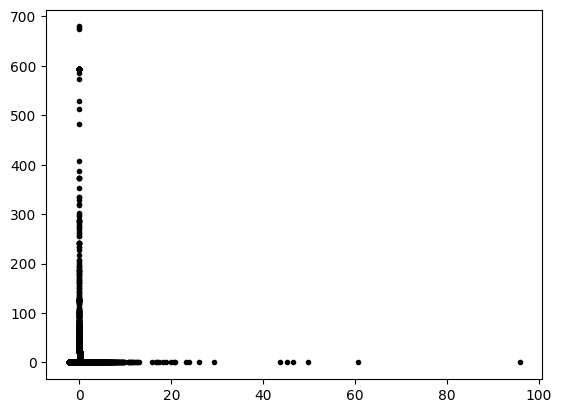

In [39]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)

rv = reciprocal(3e-4, 3e-2)
ax.plot(X_train_scaled, rv.pdf(X_train_scaled), 'k.', lw=2, label='frozen pdf')

In [54]:
rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3)
rnd_search_cv.fit(X_train_scaled, y_train, epochs=100,
                  validation_data=(X_valid_scaled, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
242/242 [==============================] - 1s 2ms/step - loss: 1.1137 - val_loss: 6.7088
Epoch 2/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6457 - val_loss: 14.2003
Epoch 3/100
242/242 [==============================] - 0s 1ms/step - loss: 0.8177 - val_loss: 15.9503
Epoch 4/100
242/242 [==============================] - 0s 1ms/step - loss: 0.8587 - val_loss: 13.5527
Epoch 5/100
242/242 [==============================] - 0s 1ms/step - loss: 0.8540 - val_loss: 22.0748
Epoch 6/100
242/242 [==============================] - 0s 1ms/step - loss: 0.8677 - val_loss: 19.7165
Epoch 7/100
242/242 [==============================] - 0s 1ms/step - loss: 0.8633 - val_loss: 18.0925
Epoch 8/100
242/242 [==============================] - 0s 1ms/step - loss: 4.2995 - val_loss: 8.5474
Epoch 9/100
242/242 [==============================] - 0s 1ms/step - loss: 0.8136 - val_loss: 27.8328
Epoch 10/100
242/242 [==============================] - 0s 1ms/step - loss: 8.1763 -

Epoch 1/100
242/242 [==============================] - 1s 2ms/step - loss: 1.8275 - val_loss: 8.3244
Epoch 2/100
242/242 [==============================] - 0s 1ms/step - loss: 1.5153 - val_loss: 128.5457
Epoch 3/100
242/242 [==============================] - 0s 1ms/step - loss: 6.5376 - val_loss: 1549.2725
Epoch 4/100
242/242 [==============================] - 0s 1ms/step - loss: 132.5451 - val_loss: 21625.7344
Epoch 5/100
242/242 [==============================] - 0s 1ms/step - loss: 2508.1384 - val_loss: 291786.0625
Epoch 6/100
242/242 [==============================] - 0s 1ms/step - loss: 13216.9443 - val_loss: 3953095.5000
Epoch 7/100
242/242 [==============================] - 0s 1ms/step - loss: 416714.6875 - val_loss: 52893188.0000
Epoch 8/100
242/242 [==============================] - 0s 1ms/step - loss: 4009584.0000 - val_loss: 712008640.0000
Epoch 9/100
242/242 [==============================] - 0s 1ms/step - loss: 53087456.0000 - val_loss: 9551125504.0000
Epoch 10/100
242/242

C:\Users\tmoia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tmoia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tmoia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 527, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tmoia\AppData\Local\Packages\PythonSoftwareFoundation.Pyth

Epoch 1/100
242/242 [==============================] - 1s 2ms/step - loss: 1.4450 - val_loss: 0.8247
Epoch 2/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5642 - val_loss: 0.9112
Epoch 3/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5397 - val_loss: 0.5995
Epoch 4/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5232 - val_loss: 0.5450
Epoch 5/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5150 - val_loss: 0.5458
Epoch 6/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5109 - val_loss: 0.5596
Epoch 7/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5065 - val_loss: 0.7514
Epoch 8/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5103 - val_loss: 0.5988
Epoch 9/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5068 - val_loss: 0.6764
Epoch 10/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5103 - val_lo

Epoch 1/100
242/242 [==============================] - 1s 2ms/step - loss: 0.9509 - val_loss: 6.8507
Epoch 2/100
242/242 [==============================] - 0s 2ms/step - loss: 0.8035 - val_loss: 0.7467
Epoch 3/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5034 - val_loss: 1.9251
Epoch 4/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4840 - val_loss: 0.6054
Epoch 5/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5088 - val_loss: 0.5423
Epoch 6/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4271 - val_loss: 0.4326
Epoch 7/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4145 - val_loss: 0.4941
Epoch 8/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4031 - val_loss: 0.4148
Epoch 9/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3964 - val_loss: 0.4392
Epoch 10/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3918 - val_lo

Epoch 1/100
242/242 [==============================] - 1s 2ms/step - loss: 1.4743 - val_loss: 30.6332
Epoch 2/100
242/242 [==============================] - 0s 1ms/step - loss: 1.2810 - val_loss: 203.3620
Epoch 3/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6851 - val_loss: 1162.7542
Epoch 4/100
242/242 [==============================] - 0s 1ms/step - loss: 5.4346 - val_loss: 0.5955
Epoch 5/100
242/242 [==============================] - 0s 1ms/step - loss: 1.3826 - val_loss: 0.6078
Epoch 6/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6507 - val_loss: 0.4950
Epoch 7/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4593 - val_loss: 0.4208
Epoch 8/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4315 - val_loss: 0.4041
Epoch 9/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5363 - val_loss: 0.6463
Epoch 10/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4324 - 

Epoch 1/100
242/242 [==============================] - 1s 2ms/step - loss: 0.8434 - val_loss: 0.9602
Epoch 2/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5177 - val_loss: 1.0532
Epoch 3/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4546 - val_loss: 0.4656
Epoch 4/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4280 - val_loss: 0.4437
Epoch 5/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4131 - val_loss: 0.6272
Epoch 6/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3982 - val_loss: 0.5036
Epoch 7/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3930 - val_loss: 0.6336
Epoch 8/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3832 - val_loss: 0.4534
Epoch 9/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3768 - val_loss: 0.6498
Epoch 10/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3714 - val_lo

Epoch 1/100
242/242 [==============================] - 1s 2ms/step - loss: 1.7668 - val_loss: 0.9462
Epoch 2/100
242/242 [==============================] - 0s 1ms/step - loss: 0.9446 - val_loss: 1.3709
Epoch 3/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5516 - val_loss: 1.3051
Epoch 4/100
242/242 [==============================] - 0s 1ms/step - loss: 0.9101 - val_loss: 1.7478
Epoch 5/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5837 - val_loss: 2.5100
Epoch 6/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6302 - val_loss: 4.0178
Epoch 7/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6806 - val_loss: 3.0156
Epoch 8/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5838 - val_loss: 2.9250
Epoch 9/100
242/242 [==============================] - 0s 1ms/step - loss: 1.2745 - val_loss: 1.7425
Epoch 10/100
242/242 [==============================] - 0s 1ms/step - loss: 0.7870 - val_lo

Epoch 1/100
242/242 [==============================] - 1s 2ms/step - loss: 1.9410 - val_loss: 85.4219
Epoch 2/100
242/242 [==============================] - 0s 1ms/step - loss: 8.7376 - val_loss: 1106.4817
Epoch 3/100
242/242 [==============================] - 0s 1ms/step - loss: 60.2877 - val_loss: 15455.9121
Epoch 4/100
242/242 [==============================] - 0s 1ms/step - loss: 713.4445 - val_loss: 205104.3281
Epoch 5/100
242/242 [==============================] - 0s 1ms/step - loss: 10196.7227 - val_loss: 2756550.0000
Epoch 6/100
242/242 [==============================] - 0s 1ms/step - loss: 326924.6875 - val_loss: 37168920.0000
Epoch 7/100
242/242 [==============================] - 0s 1ms/step - loss: 1736706.2500 - val_loss: 501303200.0000
Epoch 8/100
242/242 [==============================] - 0s 1ms/step - loss: 22461860.0000 - val_loss: 6743822336.0000
Epoch 9/100
242/242 [==============================] - 0s 1ms/step - loss: 741490112.0000 - val_loss: 90381721600.0000
Epoch

C:\Users\tmoia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tmoia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tmoia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 527, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tmoia\AppData\Local\Packages\PythonSoftwareFoundation.Pyth

Epoch 1/100
242/242 [==============================] - 1s 2ms/step - loss: 1.1724 - val_loss: 0.6023
Epoch 2/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5439 - val_loss: 0.5986
Epoch 3/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5265 - val_loss: 0.5508
Epoch 4/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5159 - val_loss: 0.5417
Epoch 5/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5100 - val_loss: 0.6559
Epoch 6/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5105 - val_loss: 0.5360
Epoch 7/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5059 - val_loss: 0.6846
Epoch 8/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5097 - val_loss: 0.5705
Epoch 9/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5077 - val_loss: 0.5841
Epoch 10/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5054 - val_lo

Epoch 1/100
242/242 [==============================] - 1s 2ms/step - loss: 0.9635 - val_loss: 49.4098
Epoch 2/100
242/242 [==============================] - 0s 1ms/step - loss: 2.1783 - val_loss: 0.5981
Epoch 3/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4751 - val_loss: 0.4580
Epoch 4/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4863 - val_loss: 0.4171
Epoch 5/100
242/242 [==============================] - 0s 1ms/step - loss: 0.7898 - val_loss: 0.4348
Epoch 6/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4271 - val_loss: 0.4190
Epoch 7/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3981 - val_loss: 0.4071
Epoch 8/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3859 - val_loss: 0.4032
Epoch 9/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3793 - val_loss: 0.3947
Epoch 10/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3730 - val_l

Epoch 1/100
242/242 [==============================] - 1s 2ms/step - loss: 0.8678 - val_loss: 8.6988
Epoch 2/100
242/242 [==============================] - 0s 1ms/step - loss: 1.4158 - val_loss: 14.3717
Epoch 3/100
242/242 [==============================] - 0s 2ms/step - loss: 0.9961 - val_loss: 602.3187
Epoch 4/100
242/242 [==============================] - 0s 2ms/step - loss: nan - val_loss: nan
Epoch 5/100
242/242 [==============================] - 0s 1ms/step - loss: nan - val_loss: nan
Epoch 6/100
242/242 [==============================] - 0s 2ms/step - loss: nan - val_loss: nan
Epoch 7/100
242/242 [==============================] - 0s 2ms/step - loss: nan - val_loss: nan
Epoch 8/100
242/242 [==============================] - 0s 1ms/step - loss: nan - val_loss: nan
Epoch 9/100
242/242 [==============================] - 0s 1ms/step - loss: nan - val_loss: nan
Epoch 10/100
242/242 [==============================] - 0s 2ms/step - loss: nan - val_loss: nan
Epoch 11/100
242/242 [======

C:\Users\tmoia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tmoia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tmoia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 527, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tmoia\AppData\Local\Packages\PythonSoftwareFoundation.Pyth

Epoch 1/100
242/242 [==============================] - 1s 2ms/step - loss: 0.8178 - val_loss: 1.4617
Epoch 2/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5157 - val_loss: 1.8552
Epoch 3/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4516 - val_loss: 1.0420
Epoch 4/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4332 - val_loss: 0.8020
Epoch 5/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4076 - val_loss: 0.4284
Epoch 6/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3948 - val_loss: 0.4622
Epoch 7/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3846 - val_loss: 0.4059
Epoch 8/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3770 - val_loss: 0.4212
Epoch 9/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3706 - val_loss: 0.3938
Epoch 10/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3661 - val_lo

Epoch 1/100
242/242 [==============================] - 1s 2ms/step - loss: 0.8325 - val_loss: 1.0931
Epoch 2/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5180 - val_loss: 0.5079
Epoch 3/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4613 - val_loss: 0.5374
Epoch 4/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4312 - val_loss: 0.4333
Epoch 5/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4110 - val_loss: 0.4533
Epoch 6/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4009 - val_loss: 0.4433
Epoch 7/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3936 - val_loss: 0.4120
Epoch 8/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3908 - val_loss: 0.4004
Epoch 9/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3833 - val_loss: 0.3929
Epoch 10/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3804 - val_lo

Epoch 1/100
242/242 [==============================] - 1s 2ms/step - loss: 1.0634 - val_loss: 6.7976
Epoch 2/100
242/242 [==============================] - 0s 1ms/step - loss: 0.9143 - val_loss: 0.9351
Epoch 3/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5180 - val_loss: 0.4446
Epoch 4/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4336 - val_loss: 0.4150
Epoch 5/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4097 - val_loss: 0.3980
Epoch 6/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3951 - val_loss: 0.3851
Epoch 7/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3831 - val_loss: 0.3736
Epoch 8/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3731 - val_loss: 0.3860
Epoch 9/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3706 - val_loss: 0.3703
Epoch 10/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3640 - val_lo

Epoch 1/100
242/242 [==============================] - 1s 2ms/step - loss: 0.8998 - val_loss: 0.6346
Epoch 2/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5544 - val_loss: 0.5982
Epoch 3/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4822 - val_loss: 0.4899
Epoch 4/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4395 - val_loss: 0.4442
Epoch 5/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4164 - val_loss: 0.5294
Epoch 6/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3944 - val_loss: 0.4161
Epoch 7/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3826 - val_loss: 0.3939
Epoch 8/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3733 - val_loss: 0.3931
Epoch 9/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3656 - val_loss: 0.4242
Epoch 10/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3592 - val_lo

Epoch 1/100
242/242 [==============================] - 1s 2ms/step - loss: 1.7941 - val_loss: 1.2959
Epoch 2/100
242/242 [==============================] - 0s 1ms/step - loss: 1.2979 - val_loss: 1.2396
Epoch 3/100
242/242 [==============================] - 0s 1ms/step - loss: 1.1782 - val_loss: 1.0516
Epoch 4/100
242/242 [==============================] - 0s 1ms/step - loss: 0.9187 - val_loss: 0.8113
Epoch 5/100
242/242 [==============================] - 0s 1ms/step - loss: 0.7449 - val_loss: 0.7072
Epoch 6/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6518 - val_loss: 0.6249
Epoch 7/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5846 - val_loss: 0.5781
Epoch 8/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6114 - val_loss: 0.6418
Epoch 9/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5985 - val_loss: 0.5968
Epoch 10/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5660 - val_lo

Epoch 1/100
242/242 [==============================] - 1s 2ms/step - loss: 1.9023 - val_loss: 1.3146
Epoch 2/100
242/242 [==============================] - 0s 1ms/step - loss: 1.4104 - val_loss: 1.3405
Epoch 3/100
242/242 [==============================] - 0s 1ms/step - loss: 1.3580 - val_loss: 1.4925
Epoch 4/100
242/242 [==============================] - 0s 1ms/step - loss: 1.4206 - val_loss: 1.9128
Epoch 5/100
242/242 [==============================] - 0s 1ms/step - loss: 1.4387 - val_loss: 1.3116
Epoch 6/100
242/242 [==============================] - 0s 1ms/step - loss: 1.3558 - val_loss: 1.2763
Epoch 7/100
242/242 [==============================] - 0s 1ms/step - loss: 1.2422 - val_loss: 1.0763
Epoch 8/100
242/242 [==============================] - 0s 1ms/step - loss: 0.9868 - val_loss: 0.8784
Epoch 9/100
242/242 [==============================] - 0s 1ms/step - loss: 0.8361 - val_loss: 0.7715
Epoch 10/100
242/242 [==============================] - 0s 1ms/step - loss: 0.7124 - val_lo

Epoch 1/100
242/242 [==============================] - 1s 2ms/step - loss: 2.0326 - val_loss: 1.3051
Epoch 2/100
242/242 [==============================] - 0s 1ms/step - loss: 1.2925 - val_loss: 1.2910
Epoch 3/100
242/242 [==============================] - 0s 1ms/step - loss: 1.2604 - val_loss: 1.2589
Epoch 4/100
242/242 [==============================] - 0s 1ms/step - loss: 1.1975 - val_loss: 1.1513
Epoch 5/100
242/242 [==============================] - 0s 1ms/step - loss: 0.9603 - val_loss: 0.8779
Epoch 6/100
242/242 [==============================] - 0s 1ms/step - loss: 0.7597 - val_loss: 0.8604
Epoch 7/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6380 - val_loss: 0.8015
Epoch 8/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5850 - val_loss: 0.5860
Epoch 9/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5416 - val_loss: 0.9356
Epoch 10/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5393 - val_lo

Epoch 1/100
242/242 [==============================] - 1s 2ms/step - loss: 1.4495 - val_loss: 8.0104
Epoch 2/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6619 - val_loss: 3.1795
Epoch 3/100
242/242 [==============================] - 0s 1ms/step - loss: 0.7317 - val_loss: 1.9321
Epoch 4/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5739 - val_loss: 0.6997
Epoch 5/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5808 - val_loss: 2.5460
Epoch 6/100
242/242 [==============================] - 0s 1ms/step - loss: 0.9709 - val_loss: 0.9283
Epoch 7/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5553 - val_loss: 0.7145
Epoch 8/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6752 - val_loss: 1.5242
Epoch 9/100
242/242 [==============================] - 0s 1ms/step - loss: 0.8735 - val_loss: 0.7121
Epoch 10/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5451 - val_lo

Epoch 1/100
242/242 [==============================] - 1s 2ms/step - loss: 1.5072 - val_loss: 78.7130
Epoch 2/100
242/242 [==============================] - 0s 1ms/step - loss: 5.4820 - val_loss: 868.7761
Epoch 3/100
242/242 [==============================] - 0s 1ms/step - loss: 56.1392 - val_loss: 11985.6836
Epoch 4/100
242/242 [==============================] - 0s 2ms/step - loss: 816.5165 - val_loss: 159708.6406
Epoch 5/100
242/242 [==============================] - 0s 1ms/step - loss: 18446.4082 - val_loss: 2146651.0000
Epoch 6/100
242/242 [==============================] - 0s 1ms/step - loss: 111454.1641 - val_loss: 28878702.0000
Epoch 7/100
242/242 [==============================] - 0s 1ms/step - loss: 2325251.7500 - val_loss: 387734368.0000
Epoch 8/100
242/242 [==============================] - 0s 1ms/step - loss: 36006096.0000 - val_loss: 5208195072.0000
Epoch 9/100
242/242 [==============================] - 0s 1ms/step - loss: 528842944.0000 - val_loss: 69858312192.0000
Epoch 

C:\Users\tmoia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tmoia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tmoia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 527, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\tmoia\AppData\Local\Packages\PythonSoftwareFoundation.Pyth

Epoch 1/100
242/242 [==============================] - 1s 2ms/step - loss: 1.2057 - val_loss: 0.7782
Epoch 2/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5465 - val_loss: 0.6173
Epoch 3/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5274 - val_loss: 0.5595
Epoch 4/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5162 - val_loss: 0.6096
Epoch 5/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5109 - val_loss: 0.6928
Epoch 6/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5088 - val_loss: 0.8085
Epoch 7/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5131 - val_loss: 0.5361
Epoch 8/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5059 - val_loss: 0.6474
Epoch 9/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5086 - val_loss: 0.5701
Epoch 10/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5077 - val_lo

Epoch 1/100
242/242 [==============================] - 1s 2ms/step - loss: 0.9998 - val_loss: 34.1795
Epoch 2/100
242/242 [==============================] - 0s 1ms/step - loss: 0.8852 - val_loss: 0.5159
Epoch 3/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4682 - val_loss: 0.4585
Epoch 4/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4341 - val_loss: 0.4365
Epoch 5/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4352 - val_loss: 0.4314
Epoch 6/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4111 - val_loss: 0.4170
Epoch 7/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4029 - val_loss: 0.4171
Epoch 8/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3977 - val_loss: 0.4231
Epoch 9/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3920 - val_loss: 0.4077
Epoch 10/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3890 - val_l

Epoch 1/100
242/242 [==============================] - 1s 2ms/step - loss: 0.9559 - val_loss: 6.1072
Epoch 2/100
242/242 [==============================] - 0s 2ms/step - loss: 0.9420 - val_loss: 4.8805
Epoch 3/100
242/242 [==============================] - 0s 1ms/step - loss: 1.0285 - val_loss: 2.5750
Epoch 4/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6175 - val_loss: 0.4824
Epoch 5/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4634 - val_loss: 0.4240
Epoch 6/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4407 - val_loss: 0.4127
Epoch 7/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4134 - val_loss: 0.4006
Epoch 8/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3966 - val_loss: 0.3893
Epoch 9/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3895 - val_loss: 0.3882
Epoch 10/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3820 - val_lo

Epoch 1/100
242/242 [==============================] - 1s 2ms/step - loss: 0.9042 - val_loss: 3.4416
Epoch 2/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5746 - val_loss: 1.4954
Epoch 3/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4705 - val_loss: 0.4810
Epoch 4/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4324 - val_loss: 0.4480
Epoch 5/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4161 - val_loss: 0.4343
Epoch 6/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4046 - val_loss: 0.4290
Epoch 7/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3947 - val_loss: 0.4140
Epoch 8/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3873 - val_loss: 0.4123
Epoch 9/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3799 - val_loss: 0.4023
Epoch 10/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3748 - val_lo

Epoch 1/100
242/242 [==============================] - 1s 2ms/step - loss: 1.7806 - val_loss: 1.3102
Epoch 2/100
242/242 [==============================] - 0s 1ms/step - loss: 1.3405 - val_loss: 1.3095
Epoch 3/100
242/242 [==============================] - 0s 1ms/step - loss: 1.3406 - val_loss: 1.3091
Epoch 4/100
242/242 [==============================] - 0s 1ms/step - loss: 1.3406 - val_loss: 1.3096
Epoch 5/100
242/242 [==============================] - 0s 1ms/step - loss: 1.3406 - val_loss: 1.3101
Epoch 6/100
242/242 [==============================] - 0s 1ms/step - loss: 1.3407 - val_loss: 1.3091
Epoch 7/100
242/242 [==============================] - 0s 1ms/step - loss: 1.3408 - val_loss: 1.3092
Epoch 8/100
242/242 [==============================] - 0s 1ms/step - loss: 1.3405 - val_loss: 1.3091
Epoch 9/100
242/242 [==============================] - 0s 1ms/step - loss: 1.3408 - val_loss: 1.3094
Epoch 10/100
242/242 [==============================] - 0s 1ms/step - loss: 1.3406 - val_lo

Epoch 1/100
242/242 [==============================] - 1s 2ms/step - loss: 1.8206 - val_loss: 1.3106
Epoch 2/100
242/242 [==============================] - 0s 2ms/step - loss: 1.3697 - val_loss: 1.3091
Epoch 3/100
242/242 [==============================] - 0s 1ms/step - loss: 1.3698 - val_loss: 1.3091
Epoch 4/100
242/242 [==============================] - 0s 2ms/step - loss: 1.3697 - val_loss: 1.3091
Epoch 5/100
242/242 [==============================] - 0s 1ms/step - loss: 1.3693 - val_loss: 1.3105
Epoch 6/100
242/242 [==============================] - 0s 1ms/step - loss: 1.3696 - val_loss: 1.3094
Epoch 7/100
242/242 [==============================] - 0s 1ms/step - loss: 1.3697 - val_loss: 1.3093
Epoch 8/100
242/242 [==============================] - 0s 1ms/step - loss: 1.3696 - val_loss: 1.3093
Epoch 9/100
242/242 [==============================] - 0s 1ms/step - loss: 1.3695 - val_loss: 1.3091
Epoch 10/100
242/242 [==============================] - 0s 2ms/step - loss: 1.3697 - val_lo

Epoch 1/100
242/242 [==============================] - 1s 2ms/step - loss: 1.7499 - val_loss: 1.3105
Epoch 2/100
242/242 [==============================] - 0s 1ms/step - loss: 1.3067 - val_loss: 1.3098
Epoch 3/100
242/242 [==============================] - 1s 3ms/step - loss: 1.3078 - val_loss: 1.3091
Epoch 4/100
242/242 [==============================] - 0s 1ms/step - loss: 1.3072 - val_loss: 1.3096
Epoch 5/100
242/242 [==============================] - 0s 1ms/step - loss: 1.3077 - val_loss: 1.3091
Epoch 6/100
242/242 [==============================] - 0s 1ms/step - loss: 1.3075 - val_loss: 1.3093
Epoch 7/100
242/242 [==============================] - 0s 1ms/step - loss: 1.3078 - val_loss: 1.3091
Epoch 8/100
242/242 [==============================] - 0s 1ms/step - loss: 1.3076 - val_loss: 1.3095
Epoch 9/100
242/242 [==============================] - 0s 1ms/step - loss: 1.3069 - val_loss: 1.3091
Epoch 10/100
242/242 [==============================] - 0s 2ms/step - loss: 1.3076 - val_lo

Epoch 1/100
242/242 [==============================] - 1s 2ms/step - loss: 0.8923 - val_loss: 1.9428
Epoch 2/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5429 - val_loss: 2.5244
Epoch 3/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4703 - val_loss: 0.4844
Epoch 4/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4566 - val_loss: 0.5610
Epoch 5/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4272 - val_loss: 0.4318
Epoch 6/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3972 - val_loss: 0.4483
Epoch 7/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3867 - val_loss: 0.3854
Epoch 8/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3748 - val_loss: 0.4231
Epoch 9/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3726 - val_loss: 0.3803
Epoch 10/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3665 - val_lo

Epoch 1/100
242/242 [==============================] - 1s 2ms/step - loss: 0.8916 - val_loss: 4.8279
Epoch 2/100
242/242 [==============================] - 0s 1ms/step - loss: 0.8370 - val_loss: 0.9379
Epoch 3/100
242/242 [==============================] - 0s 2ms/step - loss: 0.5062 - val_loss: 1.5099
Epoch 4/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5171 - val_loss: 0.4700
Epoch 5/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3994 - val_loss: 0.4060
Epoch 6/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3851 - val_loss: 0.3881
Epoch 7/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3741 - val_loss: 0.3987
Epoch 8/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3706 - val_loss: 0.3849
Epoch 9/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3639 - val_loss: 0.3894
Epoch 10/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3567 - val_lo

Epoch 1/100
242/242 [==============================] - 1s 2ms/step - loss: 0.8490 - val_loss: 0.5541
Epoch 2/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4813 - val_loss: 0.8923
Epoch 3/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4288 - val_loss: 0.5113
Epoch 4/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4041 - val_loss: 0.4147
Epoch 5/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3825 - val_loss: 0.5169
Epoch 6/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3759 - val_loss: 0.7948
Epoch 7/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3664 - val_loss: 0.5838
Epoch 8/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3581 - val_loss: 0.5863
Epoch 9/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3518 - val_loss: 0.3952
Epoch 10/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3464 - val_lo

C:\Users\tmoia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [            nan  7.59299033e-01             nan             nan
  7.68977417e-01  6.15338655e-01             nan  7.57320307e-01
 -4.98768726e-04  7.82552010e-01]
  warnings.warn(


Epoch 1/100
363/363 [==============================] - 1s 2ms/step - loss: 0.7527 - val_loss: 1.8207
Epoch 2/100
363/363 [==============================] - 0s 1ms/step - loss: 0.7655 - val_loss: 1.0785
Epoch 3/100
363/363 [==============================] - 0s 1ms/step - loss: 0.5549 - val_loss: 0.8005
Epoch 4/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3885 - val_loss: 0.4142
Epoch 5/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3718 - val_loss: 0.3989
Epoch 6/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3586 - val_loss: 0.3954
Epoch 7/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3523 - val_loss: 0.3816
Epoch 8/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3482 - val_loss: 0.3753
Epoch 9/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3389 - val_loss: 0.3744
Epoch 10/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3373 - val_lo

RandomizedSearchCV(cv=3,
                   estimator=KerasRegressor(loss='mse', model=<function build_model at 0x000002074797F9C0>, n_hidden=1, n_neurons=30, optimizer=<class 'keras.src.optimizers.sgd.SGD'>, optimizer__lr=0.003),
                   param_distributions={'n_hidden': [0, 1, 2, 3],
                                        'n_neurons': array([ 1, 11, 21, 31, 41, 51, 61, 71, 81, 91]),
                                        'optimizer__lr': array([0.0003 , 0.00327, 0.00624, 0.00921, 0.01218, 0.01515, 0.01812,
       0.02109, 0.02406, 0.02703])})

In [55]:
rnd_search_cv.best_params_

{'optimizer__lr': 0.00921, 'n_neurons': 51, 'n_hidden': 2}

In [56]:
rnd_search_cv.best_score_

0.7825520103113783

In [57]:
model = rnd_search_cv.best_estimator_.model